# Analysis 3b: Permutation test for Real World Clincally Relevant Data

Imports, Functs and Paths:

In [1]:
from statannotations.Annotator import Annotator
import os

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# plot styles
from sciplotlib import style

import matplotlib as mpl

import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

base_save_paper = "./paper_val/"
results_base = "../../results/permutations"
base_dir = "../../"
colors = [
    "#E64B35",
    "#4DBBD5",
    "#00A087",
    "#3C5488",
    "#F39B7F",
    "#8491B4",
    "#91D1C2FF",
    "#DC0000",
    "#7E6148",
    "#B09C85",
]
red = colors[0]
blue = colors[1]
green = colors[2]
purple = colors[5]


def mm_to_inch(val_in_inch):
    mm = 0.1 / 2.54
    return val_in_inch * mm


mpl.style.use(style.get_style("nature-reviews"))
mpl.rc("xtick", labelsize=11)
mpl.rc("ytick", labelsize=11)
mpl.rc("axes", labelsize=12, titlesize=12)
mpl.rc("figure", dpi=300)
mpl.rc("figure.subplot", wspace=mm_to_inch(8), hspace=0.7)
mpl.rc("lines", linewidth=1, markersize=2)

fig = plt.figure(
    figsize=[mm_to_inch(183), mm_to_inch(140)],
)


<Figure size 2161.42x1653.54 with 0 Axes>

Prepare permutations distribution and CV results:

In [2]:
#  Compute mean scores of CV for each repeat of the cross_validation:
df_scores = pd.concat(
    [pd.read_csv(results_base + "/" + i) for i in os.listdir(results_base)]
)
df_CV_results = (
    df_scores.groupby(["confound_removed", "shuffled", "repeat"])
    .agg("mean")
    .reset_index()
    .drop(columns=["fold"])
)


Now compute the p-values:

In [3]:
score_raw = df_CV_results.query(
    "(shuffled==False) & (confound_removed == False)"
).score.values
assert len(score_raw) == 1
score_raw = score_raw[0]


def compute_pval(C, n_permutations):
    """(C + 1) / (n_permutations + 1)
    where C is number of permutations greater/equal to CV score.
    """
    return (C + 1) / (n_permutations + 1)


n_permutations = (len(df_scores) - 2) / 2  # 2 conditions, both one raw rest shuffled

C_raw = (
    df_CV_results.query("(shuffled==True) & (confound_removed == False)").score
    >= score_raw
).sum()
pval_raw = compute_pval(C_raw, n_permutations)

score_rem = df_CV_results.query(
    "(shuffled==False) & (confound_removed == True)"
).score.values
assert len(score_rem) == 1
score_rem = score_rem[0]
C_rem = (
    df_CV_results.query("(shuffled==True) & (confound_removed == True)").score
    >= score_rem
).sum()
pval_rem = compute_pval(C_rem, n_permutations)

# pvals are significant (threshold .05) or not?
significance = ["*" if x < 0.05 else "n.s." for x in [pval_raw, pval_rem]]

Plot Permutation Test

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

$X_{CR}$_No vs. $X_{CR}$_Yes: n.s.


X_No vs. X_Yes: *


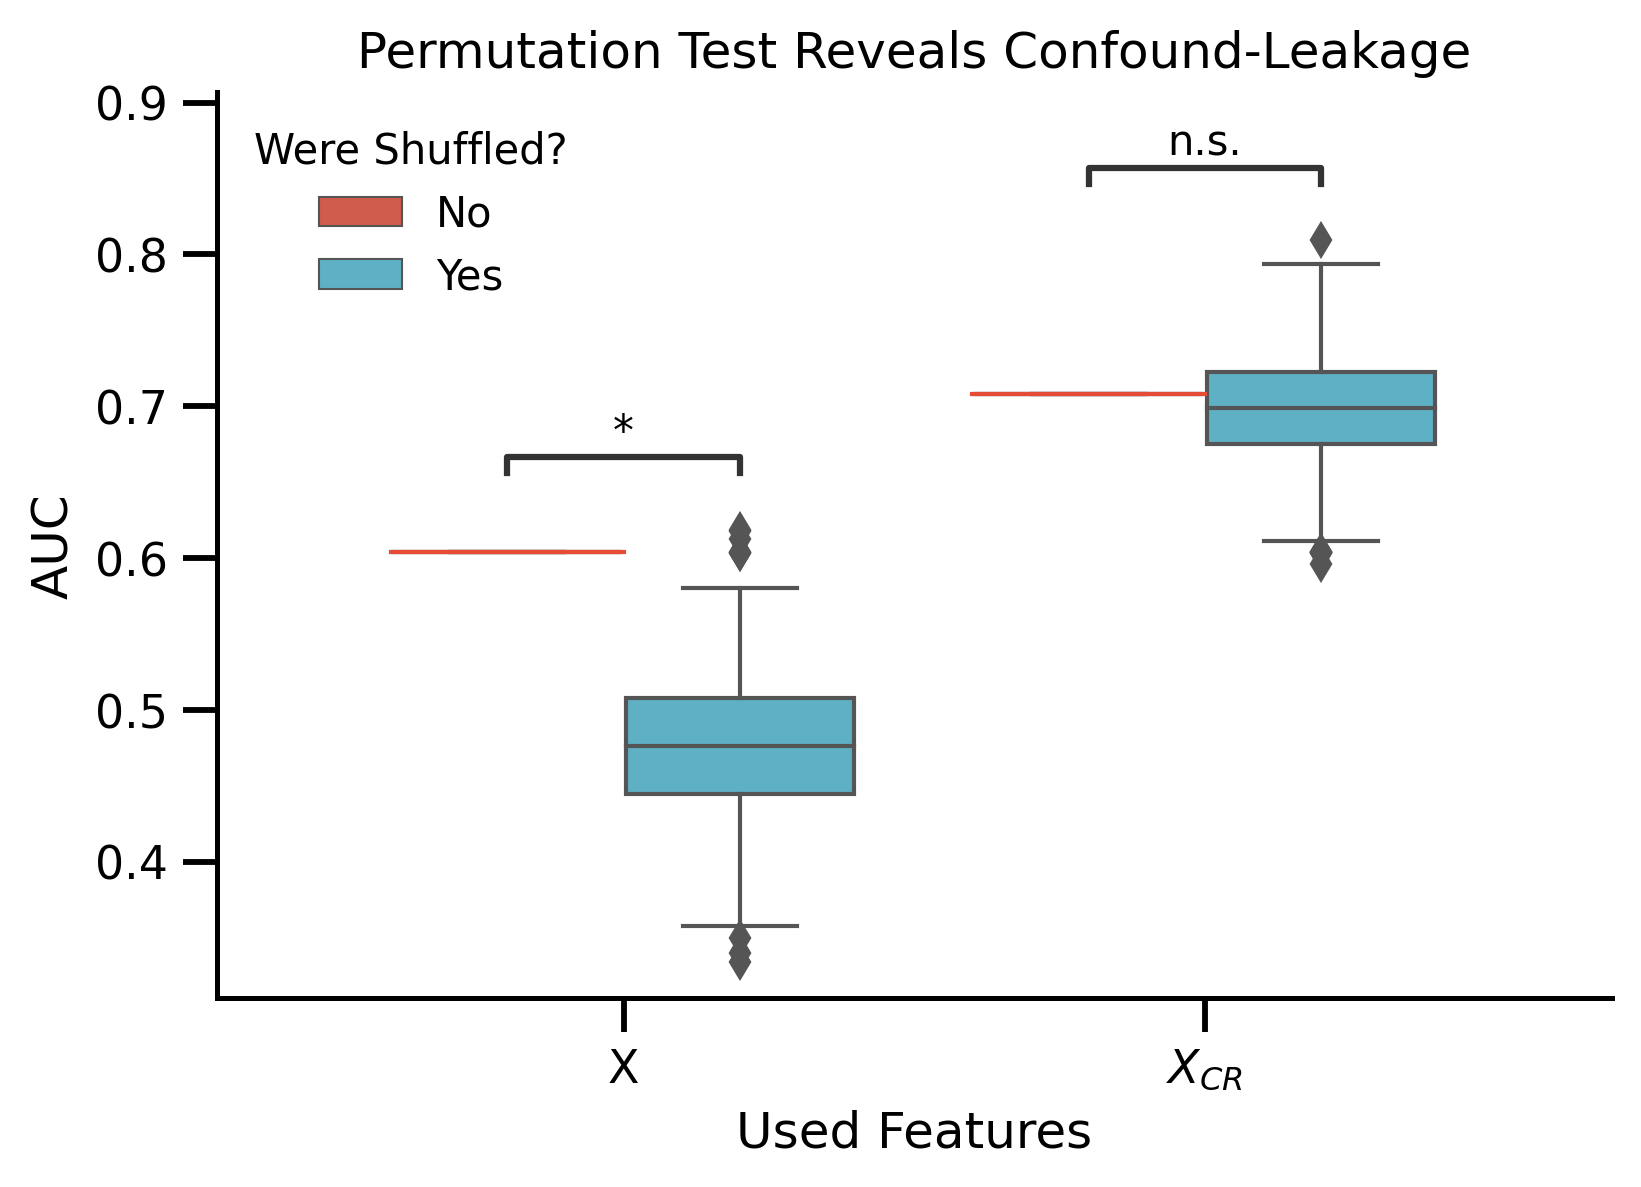

In [4]:
# Adjust dataframe for plotting
df_plot = df_CV_results.assign(
    confound_removed=lambda df: df.confound_removed.map(
        lambda x: "$X_{CR}$" if x else "X"
    ),
    shuffled=lambda df: df.shuffled.map(lambda x: "Yes" if x else "No"),
).rename(columns=dict(shuffled="Were Shuffled?", confound_removed="Features"))

# Create the actual plot
fig, ax = plt.subplots()
ax = sns.boxplot(data=df_plot, x="Features", hue="Were Shuffled?", y="score", ax=ax)
ax.plot([-0.4, 0], [score_raw, score_raw], zorder=100, c=red)
ax.plot([0.6, 1], [score_rem, score_rem], zorder=100, c=red)

# Annotate the significance
pairs = (
    [("X", "Yes"), ("X", "No")],
    [("$X_{CR}$", "Yes"), ("$X_{CR}$", "No")],
)
annotator = Annotator(
    ax, pairs, data=df_plot, x="Features", hue="Were Shuffled?", y="score"
)
annotator.set_custom_annotations(significance)
annotator.annotate()

# Change display settings
ax.set_xlabel("Used Features")
ax.set_ylabel("AUC")
ax.set_title("Permutation Test Reveals Confound-Leakage")

fig.savefig("./saved_figures/real_world_permutation.svg")
fig.savefig("./saved_figures/real_world_permutation.png")
fig.savefig("./saved_figures/real_world_permutation.pdf")